In [1]:
import tensorflow as tf
import numpy as np
import glob
import os

import matplotlib as mpl
import matplotlib.pyplot as plt

# mpl.use("agg")

# from cycler import cycler
# from itertools import cycle

mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use("ggplot")
mpl.rcParams.update({"font.size": 16})

In [89]:
import tensorflow_addons as tfa

In [2]:
def load_training_data(root_dir):
    data = {}
    data['times']                  = np.load(os.path.join(f'{root_dir}', 'times.npy'))
    data['data_processing_params'] = np.load(os.path.join(f'{root_dir}', 'data_processing_params.npz'))
    data['phase']                  = np.load(os.path.join(f'{root_dir}', 'phase.npy'))
    data['mass_ratios']            = np.load(os.path.join(f'{root_dir}', 'mass-ratios.npy'))
    data['approximants']           = np.load(os.path.join(f'{root_dir}', 'approximants.npy'))
    data['amplitude']              = np.load(os.path.join(f'{root_dir}', 'amplitude.npy'))
    
    num_waveforms = data['amplitude'].shape[0]
    indicies = np.arange(num_waveforms)
    
    data['unique_approximants'] = np.unique(data['approximants'])
    
    # mask is a dictionary with keys the same as the approximants
    # this contains the indicies of each approximant
    data['mask'] = {}
    for k in data['unique_approximants']:
        data['mask'].update({k:indicies[k == data['approximants']]})
    
    return data

In [3]:
training_data = load_training_data(root_dir="/Users/spx8sk/work/projects/wispy/dev-stack/training_data")

In [4]:
list(training_data)

['times',
 'data_processing_params',
 'phase',
 'mass_ratios',
 'approximants',
 'amplitude',
 'unique_approximants',
 'mask']

In [5]:
# lets just take the phenomD data for now

In [392]:
training_data['unique_approximants']

array(['IMRPhenomD', 'NR', 'SEOBNRv4_opt'], dtype='<U12')

In [393]:
# mask = training_data['mask']['IMRPhenomD']
mask = training_data['mask']['SEOBNRv4_opt']
y = training_data['amplitude'][mask]
# y = training_data['phase'][mask]
x = training_data['mass_ratios'][mask]

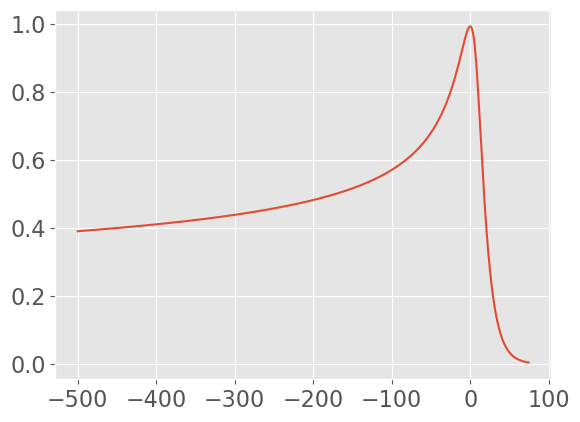

In [394]:
plt.figure()
plt.plot(training_data['times'], y[0])
plt.show()

In [152]:
# the idea here is to train an autoencoder 
# but constrain one of the latent units to be equal to the mass-ratio

In [154]:
def build_encoder(input_shape):
    
    # encoder
    timeseries_input = tf.keras.Input(shape=(input_shape,))
    x = tf.keras.layers.Dense(128, activation='relu')(timeseries_input)
    x = tf.keras.layers.Dense(16, activation='relu')(x)
    
    # normal latent space
    latent_layer = tf.keras.layers.Dense(1, activation='linear')(x)
    # q_layer is the mass_ratio unit
    q_layer = tf.keras.layers.Dense(1, activation='linear', name='q_output')(x)
    
    model = tf.keras.Model(inputs=timeseries_input, outputs=[q_layer, latent_layer])
    
    return model
    

In [155]:
encoder = build_encoder(input_shape=y.shape[1])

In [156]:
encoder.summary()

Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_22 (InputLayer)           [(None, 1150)]       0                                            
__________________________________________________________________________________________________
dense_36 (Dense)                (None, 128)          147328      input_22[0][0]                   
__________________________________________________________________________________________________
dense_37 (Dense)                (None, 16)           2064        dense_36[0][0]                   
__________________________________________________________________________________________________
q_output (Dense)                (None, 1)            17          dense_37[0][0]                   
___________________________________________________________________________________________

In [157]:
# encoder.predict(y)

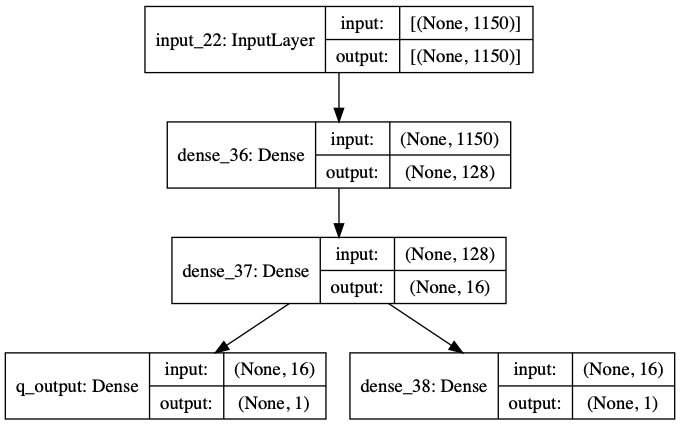

In [158]:
tf.keras.utils.plot_model(encoder, show_shapes=True)

In [159]:
def build_decoder(output_shape):
    
    q_input = tf.keras.Input(shape=(1,), name='q_input')
    latent_input = tf.keras.Input(shape=(1,))
    
    input_concat = tf.keras.layers.concatenate([q_input, latent_input])
    
    x = tf.keras.layers.Dense(16, activation='relu')(input_concat)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    timeseries_output = tf.keras.layers.Dense(output_shape, activation="linear", name='final_output')(x)
    
    model = tf.keras.Model(inputs=[q_input, latent_input], outputs=timeseries_output)
    
    return model
    

In [160]:
decoder = build_decoder(y.shape[1])

In [161]:
decoder.summary()

Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
q_input (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_23 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 2)            0           q_input[0][0]                    
                                                                 input_23[0][0]                   
__________________________________________________________________________________________________
dense_39 (Dense)                (None, 16)           48          concatenate_7[0][0]       

In [162]:
qin = np.array([1]).reshape(-1,1)
lin = np.array([1]).reshape(-1,1)

In [163]:
decoder.predict([ qin, lin ])

array([[-0.07158172, -0.00744243, -0.05865134, ...,  0.02226966,
        -0.0516835 , -0.0577601 ]], dtype=float32)

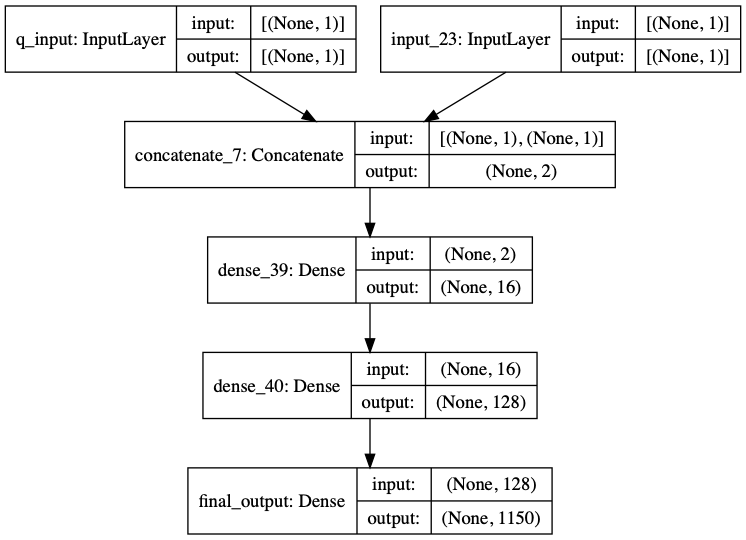

In [164]:
tf.keras.utils.plot_model(decoder, show_shapes=True)

In [165]:
input_shape = y.shape[1]
timeseries_input = tf.keras.Input(shape=(input_shape, ))
latent_q, latent_l = encoder(timeseries_input)
timeseries_output = decoder([latent_q, latent_l])
ae_model = tf.keras.Model(timeseries_input, timeseries_output)

In [166]:
ae_model.summary()

Model: "model_16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_24 (InputLayer)           [(None, 1150)]       0                                            
__________________________________________________________________________________________________
model_14 (Functional)           [(None, 1), (None, 1 149426      input_24[0][0]                   
__________________________________________________________________________________________________
model_15 (Functional)           (None, 1150)         150574      model_14[0][0]                   
                                                                 model_14[0][1]                   
Total params: 300,000
Trainable params: 300,000
Non-trainable params: 0
__________________________________________________________________________________________________


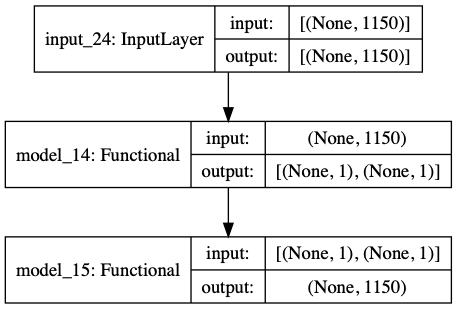

In [167]:
tf.keras.utils.plot_model(ae_model, show_shapes=True)

In [173]:
losses = {
    'q_output':'mse',
    'final_output':'mse'
}

In [177]:
# ae_model.compile(optimizer='Adam', loss=losses)
ae_model.compile(optimizer='Adam', loss='mse')

In [178]:
# callbacks=[]
# tqdm_callback = tfa.callbacks.TQDMProgressBar(show_epoch_progress=False)
# callbacks.append(tqdm_callback)
# history = ae_model.fit(
#     y,
#     y={'q_output':x, 'final_output':y},
#     epochs=1000, callbacks=callbacks, verbose=0)

callbacks=[]
tqdm_callback = tfa.callbacks.TQDMProgressBar(show_epoch_progress=False)
callbacks.append(tqdm_callback)
history = ae_model.fit(y, y, epochs=1000, callbacks=callbacks, verbose=0)

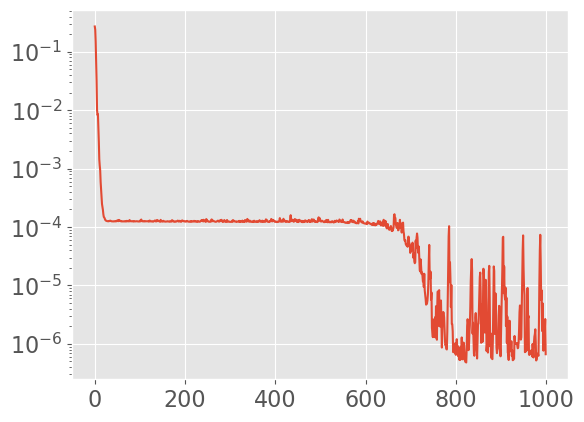

In [179]:
plt.figure()
plt.plot(history.history['loss'])
plt.yscale('log')
plt.show()

In [180]:
encodings = encoder.predict(y) 

In [181]:
len(encodings)

2

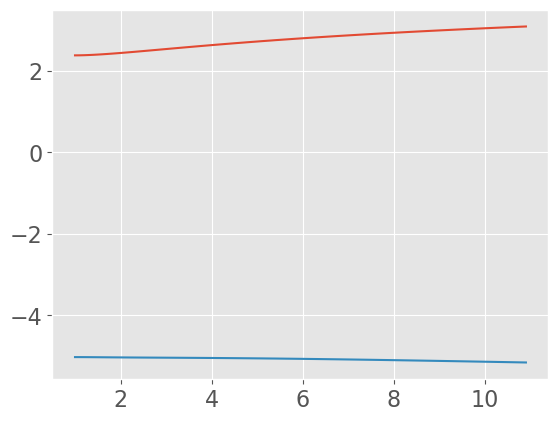

In [182]:
plt.figure()
plt.plot(x, encodings[0])
plt.plot(x, encodings[1])
plt.show()

# try end to end

In [271]:
def build_end_to_end(input_shape, output_shape):
    
    # encoder
    timeseries_input = tf.keras.Input(shape=(input_shape,))
    x = tf.keras.layers.Dense(128, activation='relu')(timeseries_input)
    x = tf.keras.layers.Dense(16, activation='relu')(x)
    
    # normal latent space
    latent_layer = tf.keras.layers.Dense(1, activation='linear')(x)
    # q_layer is the mass_ratio unit
    q_layer = tf.keras.layers.Dense(1, activation='linear', name='q_output')(x)
    
#     model = tf.keras.Model(inputs=timeseries_input, outputs=[q_layer, latent_layer])
    
    
#     q_input = tf.keras.Input(shape=(1,), name='q_input')
#     latent_input = tf.keras.Input(shape=(1,))
    
    input_concat = tf.keras.layers.concatenate([q_layer, latent_layer])
    
    x = tf.keras.layers.Dense(16, activation='relu')(input_concat)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    timeseries_output = tf.keras.layers.Dense(output_shape, activation="linear", name='final_output')(x)
    
    model = tf.keras.Model(inputs=timeseries_input, outputs=[q_layer, latent_layer, timeseries_output])
    
    return model

In [272]:
ae_model = build_end_to_end(y.shape[1], y.shape[1])

In [273]:
ae_model.summary()

Model: "model_20"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_28 (InputLayer)           [(None, 1150)]       0                                            
__________________________________________________________________________________________________
dense_56 (Dense)                (None, 128)          147328      input_28[0][0]                   
__________________________________________________________________________________________________
dense_57 (Dense)                (None, 16)           2064        dense_56[0][0]                   
__________________________________________________________________________________________________
q_output (Dense)                (None, 1)            17          dense_57[0][0]                   
___________________________________________________________________________________________

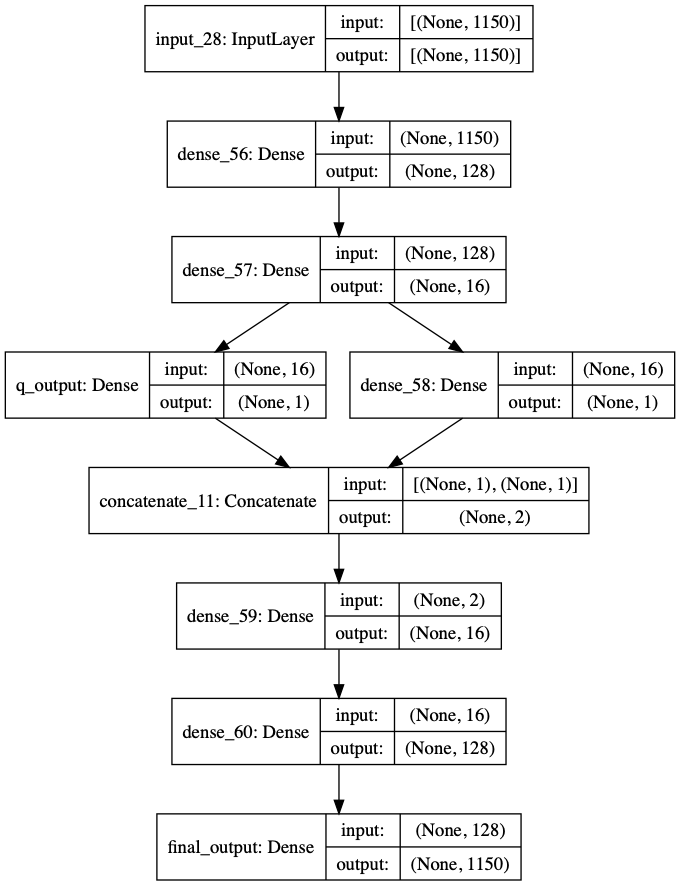

In [274]:
tf.keras.utils.plot_model(ae_model, show_shapes=True)

In [275]:
# ae_model.predict(y)

In [276]:
losses = {
    'q_output':'mse',
    'final_output':'mse'
}

In [277]:
ae_model.compile(optimizer='Adam', loss=losses)
# ae_model.compile(optimizer='Adam', loss='mse')

In [278]:
callbacks=[]
tqdm_callback = tfa.callbacks.TQDMProgressBar(show_epoch_progress=False)
callbacks.append(tqdm_callback)
history = ae_model.fit(
    y,
    y={'q_output':x, 'final_output':y},
    epochs=1000, callbacks=callbacks, verbose=0)

In [279]:
history.history.keys()

dict_keys(['loss', 'q_output_loss', 'final_output_loss'])

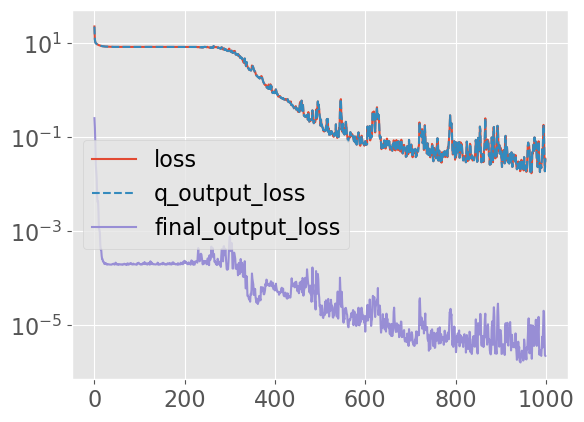

In [280]:
plt.figure()
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['q_output_loss'], label='q_output_loss', ls='--')
plt.plot(history.history['final_output_loss'], label='final_output_loss')
plt.yscale('log')
plt.legend()
plt.show()

In [281]:
q_out, l_out, yhat = ae_model.predict(y)

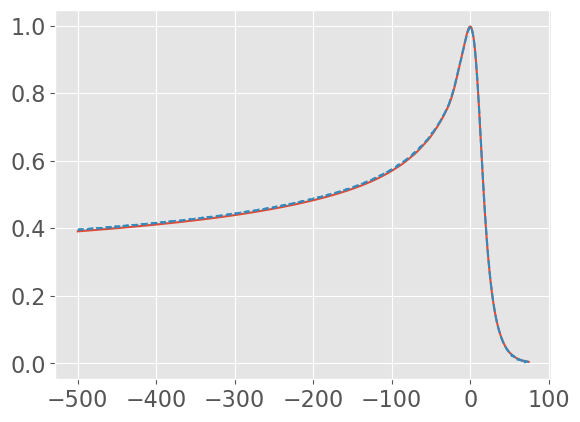

In [282]:
plt.figure()
plt.plot(training_data['times'], y[0])
plt.plot(training_data['times'], yhat[0], ls='--')
plt.show()

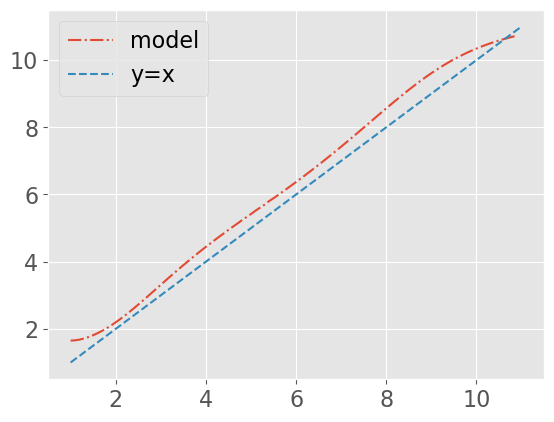

In [283]:
plt.figure()
plt.plot(x, q_out, '-.', label='model')
plt.plot(np.arange(1, 12), np.arange(1, 12), ls='--', label='y=x')
plt.legend()
plt.show()

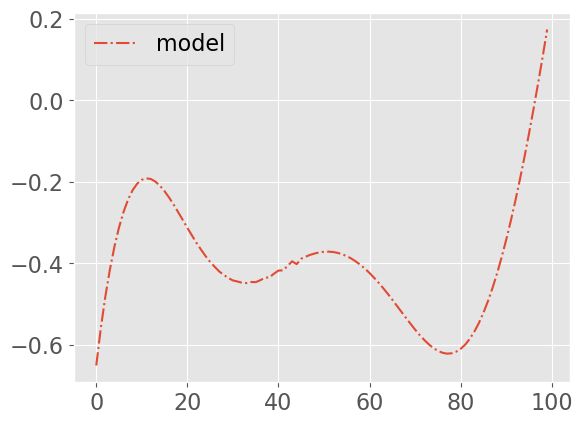

In [284]:
plt.figure()
plt.plot(x-q_out[:,0], '-.', label='model')
plt.legend()
plt.show()

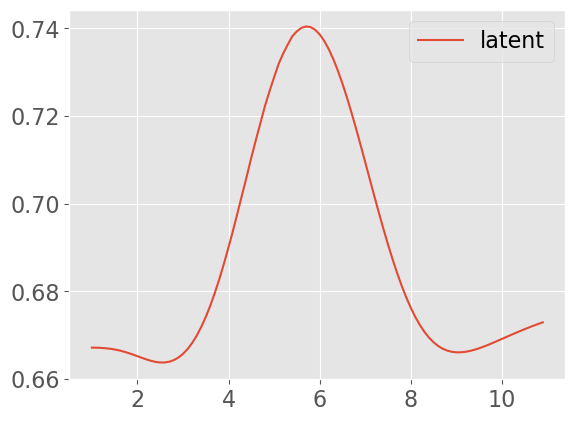

In [286]:
plt.figure()
# plt.plot(x, q_out, label='q')
plt.plot(x, l_out, label='latent')
plt.legend()
plt.show()

# try end to end - but now instead of training to be equal to q just set q as an input

In [699]:
def build_end_to_end_q_input(input_shape, output_shape, latent_dim):
    
    # encoder
    timeseries_input = tf.keras.Input(shape=(input_shape,), name='input_y')
    x = tf.keras.layers.Dense(128)(timeseries_input)
#     x = tf.keras.layers.ELU()(x)
#     x = tf.keras.layers.ReLU()(x)
#     x = tf.keras.layers.PReLU()(x)
#     x = tf.keras.layers.Activation(activation='sigmoid')(x)
#     x = tf.keras.layers.Activation(activation=tf.keras.activations.selu)(x)
#     x = tf.keras.layers.Activation(activation=tf.keras.activations.gelu)(x)
    x = tfa.activations.mish(x)
    x = tf.keras.layers.Dense(128)(x)
#     x = tf.keras.layers.ELU()(x)
#     x = tf.keras.layers.ReLU()(x)
#     x = tf.keras.layers.PReLU()(x)
#     x = tf.keras.layers.Activation(activation='sigmoid')(x)
#     x = tf.keras.layers.Activation(activation=tf.keras.activations.selu)(x)
#     x = tf.keras.layers.Activation(activation=tf.keras.activations.gelu)(x)
    x = tfa.activations.mish(x)
    x = tf.keras.layers.Dense(16)(x)
#     x = tf.keras.layers.ELU()(x)
#     x = tf.keras.layers.ReLU()(x)
#     x = tf.keras.layers.PReLU()(x)
#     x = tf.keras.layers.Activation(activation='sigmoid')(x)
#     x = tf.keras.layers.Activation(activation=tf.keras.activations.selu)(x)
#     x = tf.keras.layers.Activation(activation=tf.keras.activations.gelu)(x)
    x = tfa.activations.mish(x)
    
    # normal latent space
    latent_layer = tf.keras.layers.Dense(latent_dim, activation='linear')(x)
    # q_layer is the mass_ratio unit
    
#     q_layer = tf.keras.layers.Dense(1, activation='linear', name='q_output')(x)
    q_layer = tf.keras.Input(shape=(1,), name='input_q')
    
#     model = tf.keras.Model(inputs=timeseries_input, outputs=[q_layer, latent_layer])
    
    
#     q_input = tf.keras.Input(shape=(1,), name='q_input')
#     latent_input = tf.keras.Input(shape=(1,))
    
#     input_concat = tf.keras.layers.concatenate([q_layer, latent_layer])
    input_concat = tf.keras.layers.concatenate([q_layer, latent_layer])
    
    x = tf.keras.layers.Dense(16)(input_concat)
#     x = tf.keras.layers.ELU()(x)
#     x = tf.keras.layers.ReLU()(x)
#     x = tf.keras.layers.PReLU()(x)
#     x = tf.keras.layers.Activation(activation='sigmoid')(x)
#     x = tf.keras.layers.Activation(activation=tf.keras.activations.selu)(x)
#     x = tf.keras.layers.Activation(activation=tf.keras.activations.gelu)(x)
    x = tfa.activations.mish(x)
    x = tf.keras.layers.Dense(128)(x)
#     x = tf.keras.layers.ELU()(x)
#     x = tf.keras.layers.ReLU()(x)
#     x = tf.keras.layers.PReLU()(x)
#     x = tf.keras.layers.Activation(activation='sigmoid')(x)
#     x = tf.keras.layers.Activation(activation=tf.keras.activations.selu)(x)
#     x = tf.keras.layers.Activation(activation=tf.keras.activations.gelu)(x)
    x = tfa.activations.mish(x)
    x = tf.keras.layers.Dense(128)(x)
#     x = tf.keras.layers.ELU()(x)
#     x = tf.keras.layers.ReLU()(x)
#     x = tf.keras.layers.PReLU()(x)
#     x = tf.keras.layers.Activation(activation='sigmoid')(x)
#     x = tf.keras.layers.Activation(activation=tf.keras.activations.selu)(x)
#     x = tf.keras.layers.Activation(activation=tf.keras.activations.gelu)(x)
    x = tfa.activations.mish(x)

    x = tf.keras.layers.Dense(128)(x)
#     x = tf.keras.layers.ReLU()(x)
    x = tfa.activations.mish(x)
    x = tf.keras.layers.Dense(128)(x)
#     x = tf.keras.layers.ReLU()(x)
    x = tfa.activations.mish(x)
    x = tf.keras.layers.Dense(128)(x)
#     x = tf.keras.layers.ReLU()(x)
    x = tfa.activations.mish(x)
    x = tf.keras.layers.Dense(128)(x)
#     x = tf.keras.layers.ReLU()(x)
    x = tfa.activations.mish(x)
    x = tf.keras.layers.Dense(128)(x)
#     x = tf.keras.layers.ReLU()(x)
    x = tfa.activations.mish(x)
    x = tf.keras.layers.Dense(128)(x)
#     x = tf.keras.layers.ReLU()(x)
    x = tfa.activations.mish(x)


    timeseries_output = tf.keras.layers.Dense(output_shape, activation="linear", name='final_output')(x)
    
    model = tf.keras.Model(inputs=[q_layer, timeseries_input], outputs=[latent_layer, timeseries_output])
    
    return model

In [700]:
ae_model = build_end_to_end_q_input(y.shape[1], y.shape[1], 1)

In [701]:
ae_model.summary()

Model: "model_40"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_y (InputLayer)            [(None, 1150)]       0                                            
__________________________________________________________________________________________________
dense_208 (Dense)               (None, 128)          147328      input_y[0][0]                    
__________________________________________________________________________________________________
tf.convert_to_tensor_31 (TFOpLa (None, 128)          0           dense_208[0][0]                  
__________________________________________________________________________________________________
tf.math.softplus_31 (TFOpLambda (None, 128)          0           tf.convert_to_tensor_31[0][0]    
___________________________________________________________________________________________

In [702]:
# tf.keras.utils.plot_model(ae_model, show_shapes=True)

In [703]:
# ae_model.predict(y)

In [704]:
losses = {
    'final_output':'mse'
}

In [705]:
ae_model.compile(optimizer='adamax', loss=losses)
# ae_model.compile(optimizer='Adam', loss='mse')

In [713]:
%%time
callbacks=[]
tqdm_callback = tfa.callbacks.TQDMProgressBar(show_epoch_progress=False)
callbacks.append(tqdm_callback)
history = ae_model.fit(
    x={'input_q':x, 'input_y':y},
    y={'final_output':y},
    epochs=10000, callbacks=callbacks, verbose=0)


CPU times: user 4min 12s, sys: 42 s, total: 4min 54s
Wall time: 2min


In [714]:
history.history.keys()

dict_keys(['loss', 'final_output_loss'])

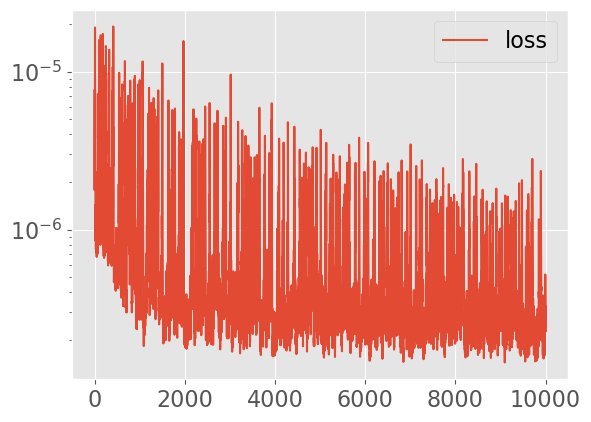

In [715]:
plt.figure()
plt.plot(history.history['loss'], label='loss')
# plt.plot(history.history['final_output_loss'], label='final_output_loss')
plt.yscale('log')
plt.legend()
plt.show()

In [716]:
l_out, yhat = ae_model.predict([x, y])

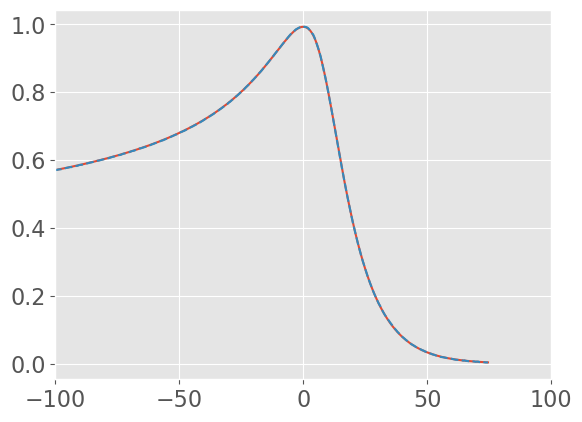

In [717]:
plt.figure()
plt.plot(training_data['times'], y[0])
plt.plot(training_data['times'], yhat[0], ls='--')
plt.xlim(-100, 100)
plt.show()

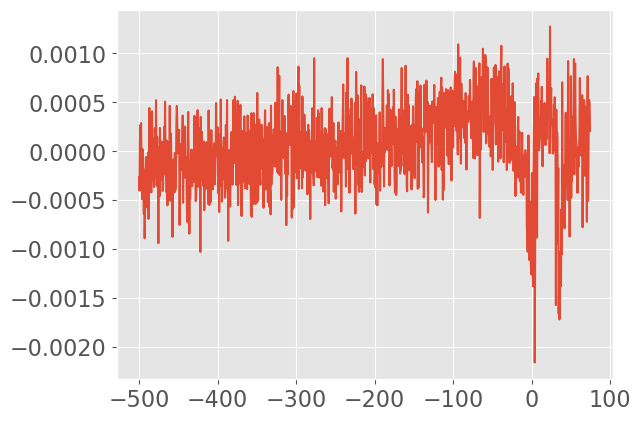

In [722]:
plt.figure()
plt.plot(training_data['times'], y[0]-yhat[0])
# plt.plot(training_data['times'], y[-1]-yhat[-1])
# plt.xlim(-100, 100)
plt.show()

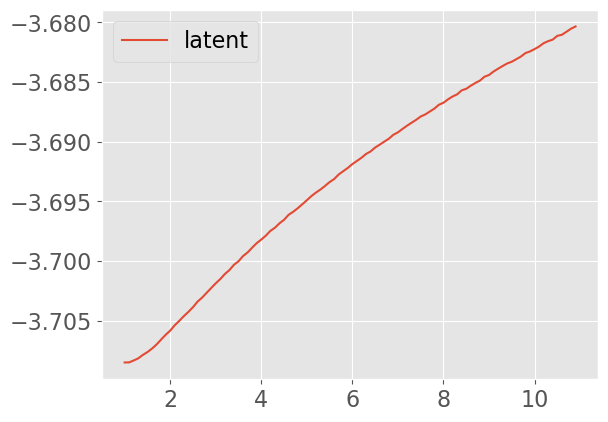

In [719]:
plt.figure()
# plt.plot(x, q_out, label='q')
plt.plot(x, l_out, label='latent')
plt.legend()
plt.show()